In [4]:
!jt -t chesterish

In [5]:
import numpy as np
import pandas as pd
from pandas import read_csv



In [6]:
df_train = read_csv("SYSC4415W23_A3_dataset/train/extracted_features.csv")
df_train_labels = read_csv("SYSC4415W23_A3_dataset/train/labels.csv")




# Replace infinite values with a valid value
df_train = df_train.replace([np.inf, -np.inf], np.nan)
df_train = df_train.fillna(df_train.max())

df_train  = df_train.replace([np.inf, -np.inf], np.nan)
df_train_labels  = df_train_labels.fillna(df_train_labels.max())

#remove NaN values replace with zero
df_train = df_train.fillna(0)
df_train_labels = df_train_labels.fillna(0)

#sort numerically 
df_train = df_train.sort_values('sample_id', ascending=True)
df_train_labels = df_train_labels.sort_values('sample_id', ascending=True)




In [7]:
print(df_train.head())
print(df_train.shape)

      sample_id  az__variance_larger_than_standard_deviation  \
1018          1                                          1.0   
1533          2                                          1.0   
1346          3                                          1.0   
426           4                                          1.0   
60            6                                          1.0   

      az__has_duplicate_max  az__has_duplicate_min  az__has_duplicate  \
1018                    0.0                    0.0                1.0   
1533                    1.0                    1.0                1.0   
1346                    0.0                    0.0                1.0   
426                     0.0                    0.0                1.0   
60                      0.0                    0.0                1.0   

      az__sum_values  az__abs_energy  az__mean_abs_change  az__mean_change  \
1018      -11.405649     2958.427875             0.285573        -0.000523   
1533        4.430022

In [8]:
print(df_train_labels.head())

      sample_id  label
1576          1      3
1213          2      3
567           3      4
1283          4      1
1015          6      4


In [9]:
print(len(df_train))

print(len(df_train_labels))

1621
1621


In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2,mutual_info_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten


In [108]:
X = df_train.values
y = df_train_labels['label']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = df_train.columns
n = 2500
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=n)
selector.fit(X_train, y_train)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# create a new DataFrame with the selected features
selected_features = feature_names[selector.get_support()]

# print the selected features
print(selected_features)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Reshape the data
X_train = X_train_scaled.reshape((X_train.shape[0], 1, n, 1))
X_test = X_test_scaled.reshape((X_test.shape[0], 1, n, 1))




import pickle

with open('selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

C:\Users\james\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  12   46   49   50   51   52   53   54   55   56   57   58   59   60
   61   62   63   64   65   66   72   73   74   75   76   77   78   79
   80   81   82   83   84   93  106  366  764  782  795  829  832  833
  834  835  836  837  838  839  840  841  842  843  844  845  846  847
  848  849  854  855  856  857  858  859  860  861  862  863  864  865
  866  867  876  889 1149 1565 1578 1612 1614 1615 1616 1617 1618 1619
 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1638
 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1659 1672
 1932 2330 2348 2361 2395 2398 2399 2400 2401 2402 2403 2404 2405 2406
 2407 2408 2409 2410 2411 2412 2413 2414 2415 2421 2422 2423 2424 2425
 2426 2427 2428 2429 2430 2431 2432 2433 2442 2455 2715 3131 3144 3178
 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195
 3196 3197 3198 3199 3205 3

Index(['az__variance_larger_than_standard_deviation', 'az__has_duplicate',
       'az__sum_values', 'az__abs_energy', 'az__mean_abs_change',
       'az__mean_change', 'az__median', 'az__mean', 'az__standard_deviation',
       'az__variance',
       ...
       'wx__ratio_beyond_r_sigma__r_2', 'wx__ratio_beyond_r_sigma__r_2.5',
       'wx__ratio_beyond_r_sigma__r_3', 'wx__fourier_entropy__bins_2',
       'wx__fourier_entropy__bins_3', 'wx__fourier_entropy__bins_5',
       'wx__fourier_entropy__bins_10', 'wx__fourier_entropy__bins_100',
       'wx__permutation_entropy__dimension_7__tau_1',
       'wx__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=2500)


In [63]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (1,1), activation='relu', input_shape=(1, n, 1)))
model.add(MaxPooling2D((1,1)))
model.add(Conv2D(64, (1,1), activation='relu'))
model.add(MaxPooling2D((1,1)))
model.add(Conv2D(128, (1,1), activation='relu'))
model.add(MaxPooling2D((1,1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


Epoch 1/30
41/41 [==============================] - 40s 951ms/step - loss: 1.6372 - accuracy: 0.5378 - val_loss: 0.9659 - val_accuracy: 0.6708
Epoch 2/30
41/41 [==============================] - 39s 956ms/step - loss: 0.6284 - accuracy: 0.7631 - val_loss: 0.6723 - val_accuracy: 0.7662
Epoch 3/30
41/41 [==============================] - 39s 958ms/step - loss: 0.3894 - accuracy: 0.8526 - val_loss: 0.7584 - val_accuracy: 0.7631
Epoch 4/30
41/41 [==============================] - 39s 956ms/step - loss: 0.2092 - accuracy: 0.9275 - val_loss: 0.6348 - val_accuracy: 0.8000
Epoch 5/30
41/41 [==============================] - 39s 953ms/step - loss: 0.0987 - accuracy: 0.9745 - val_loss: 0.8295 - val_accuracy: 0.7969
Epoch 6/30
41/41 [==============================] - 39s 953ms/step - loss: 0.0604 - accuracy: 0.9907 - val_loss: 1.0960 - val_accuracy: 0.8123
Epoch 7/30
41/41 [==============================] - 39s 953ms/step - loss: 0.0225 - accuracy: 0.9969 - val_loss: 0.8876 - val_accuracy: 0.8123

In [64]:
model.save('CNN_motion.h5')

In [73]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size =32)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

11/11 [==============================] - 1s 80ms/step - loss: 2.2606 - accuracy: 0.8338
Test accuracy: 0.8338461518287659
Test loss: 2.260561943054199


In [187]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print("y_true" , y_true.shape)
print("----------------------------")
print('y_pred', y_pred.shape)

11/11 [==============================] - 1s 80ms/step
y_true (325,)
----------------------------
y_pred (325,)


In [199]:
from sklearn.metrics import accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
accuracy_toCSV = accuracy


# Initialize an array to store the accuracy values
accuracies = np.zeros(20)

# Repeat the prediction and evaluation process for the specified number of times
for i in range(20):
    # Use the predict() method to obtain the predicted class labels for the test data
    y_pred = model.predict(X_test)
    # Convert the predicted probabilities to class labels
    y_pred = np.argmax(y_pred, axis=1)
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    # Store the accuracy value in the array
    accuracies[i] = accuracy

# Calculate the standard deviation of the obtained accuracy values
std_accuracy = np.std(accuracies)



print('Standard deviation of accuracy:', std_accuracy)




Accuracy: 0.8215384615384616
11/11 [==============================] - 1s 83ms/step
Standard deviation of accuracy: 1.1102230246251565e-16


In [196]:
import csv

file_name = '25_predicted_performance.csv'
mode = 'w'

# Open the file in the specified mode using the csv.writer() function
with open(file_name, mode, newline='') as file:
    writer = csv.writer(file)

    # Write the headers for each column
    writer.writerow(['predicted_accuracy', 'predicted_accuracy_std'])

    # Write values to each column using the writerows() method
    rows = [[accuracy_toCSV, std_accuracy]]
    writer.writerows(rows)


In [202]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

11/11 [==============================] - 1s 94ms/step
[[56  1 12  2  1]
 [ 4 49  3  1  3]
 [ 4  3 44  9  1]
 [ 5  4  5 56  0]
 [ 0  0  0  0 62]]


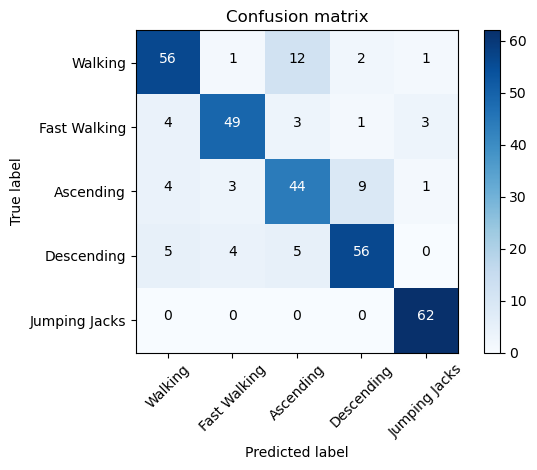

In [80]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Example usage with a 5x5 matrix

classes = ['Walking', 'Fast Walking', 'Ascending', 'Descending', 'Jumping Jacks']

plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix')
plt.show()

11/11 [==============================] - 1s 79ms/step


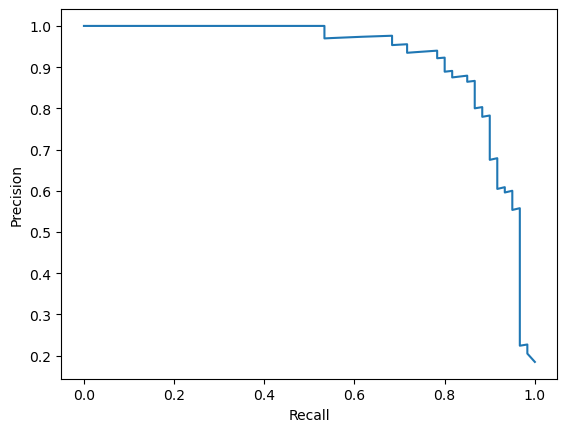

In [79]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score




# Predict probabilities for test data
y_proba = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = np.argmax(y_proba, axis=1)

# Calculate precision and recall for each class
precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1], pos_label=1)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


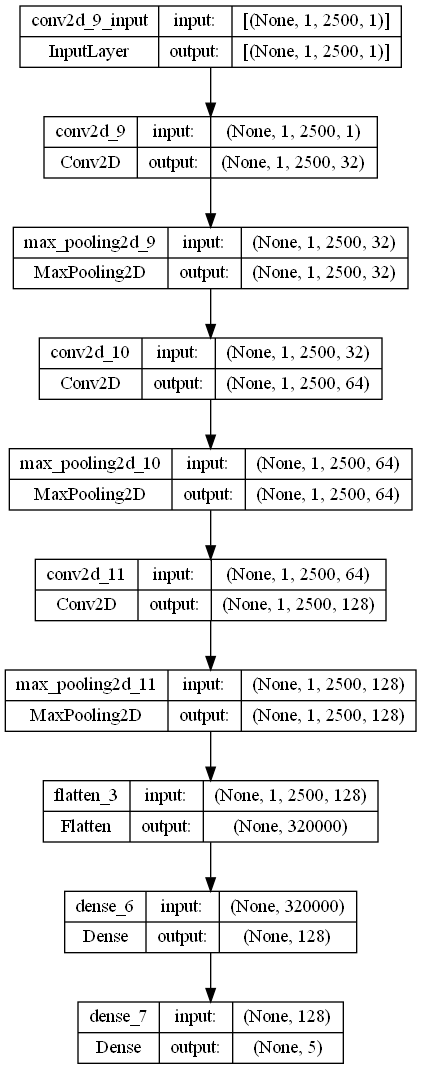

In [66]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [45]:
df_test = read_csv("SYSC4415W23_A3_dataset/test/extracted_features.csv")
df_test_labels = read_csv("SYSC4415W23_A3_dataset/test/labels.csv")

# Replace infinite values with a valid value
df_test = df_test.replace([np.inf, -np.inf], np.nan)
df_test = df_test.fillna(df_test.max())

df_test  = df_test.replace([np.inf, -np.inf], np.nan)
df_test_labels  = df_test_labels.fillna(df_test.max())

#remove NaN values replace with zero
df_test = df_test.fillna(0)
df_test_labels = df_test_labels.fillna(0)

#sort numerically 
df_test = df_test.sort_values('sample_id', ascending=True)
df_test_labels = df_test_labels.sort_values('sample_id', ascending=True)

In [68]:
print(df_test_labels.head())

     sample_id
146          0
260          5
30          13
163         14
84          23


In [111]:
from tensorflow.keras.models import load_model
# load saved feature selector object
with open('selector.pkl', 'rb') as f:
    selector = pickle.load(f)
#load model
model = load_model('CNN_motion.h5')
# load new data
new_data = df_test

# transform new data to have same shape as input data used to train the model
new_data_transformed = selector.transform(new_data)
new_data_transformed = scaler.transform(new_data_transformed)

# reshape new data to fit the input shape of the CNN model
new_data_transformed = np.reshape(new_data_transformed, (new_data_transformed.shape[0], 1, n, 1))

# make predictions on new data using trained CNN model
y_pred = model.predict(new_data_transformed)
y_pred_classes = np.argmax(y_pred, axis=1)

# save predictions to a CSV file
np.savetxt('predicted_classes.csv', y_pred_classes, delimiter=',')

print(y_pred_classes.shape)
print(y_pred_classes)











C:\Users\james\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


9/9 [==============================] - 1s 86ms/step
(287,)
[1 2 2 4 1 0 0 4 0 3 3 3 3 0 0 3 4 2 3 2 4 4 2 0 4 4 1 3 2 2 1 1 3 3 1 0 2
 2 0 0 4 1 2 3 1 4 4 1 2 4 2 2 0 4 2 2 4 2 4 2 0 3 0 2 2 2 4 0 3 0 0 1 1 4
 2 2 1 1 4 4 0 3 0 4 2 1 4 4 1 2 1 0 2 1 1 1 0 0 4 3 2 1 3 4 1 3 1 2 3 3 3
 1 2 2 4 3 0 0 1 3 3 2 0 1 0 4 3 0 3 2 2 3 2 1 3 0 4 1 3 1 2 4 4 1 0 3 0 3
 4 2 2 4 4 0 3 3 1 1 0 1 2 3 3 4 2 1 4 4 4 2 2 0 3 4 0 0 2 4 0 1 1 2 3 0 1
 1 4 0 0 3 2 1 0 2 4 4 0 2 4 2 2 1 4 1 0 3 2 4 1 2 1 4 0 2 1 3 1 1 1 2 3 1
 4 3 1 0 0 1 1 3 3 0 0 4 2 2 4 0 2 1 4 3 1 2 2 4 3 2 4 4 1 3 4 2 0 3 4 1 1
 2 4 0 4 0 3 4 3 0 2 0 4 0 0 1 2 2 2 0 3 3 3 3 3 0 1 0 2]


In [116]:
df = pd.DataFrame(df_test_labels)

df_predictions = pd.concat([df, pd.DataFrame({'label': y_pred_classes})], axis=1)

print(df_predictions)


df_predictions.to_csv('25_predictions.csv', index=False)

     sample_id  label
146          0      0
260          5      4
30          13      1
163         14      4
84          23      2
..         ...    ...
140       1895      2
95        1897      1
87        1898      4
171       1903      0
169       1905      2

[287 rows x 2 columns]


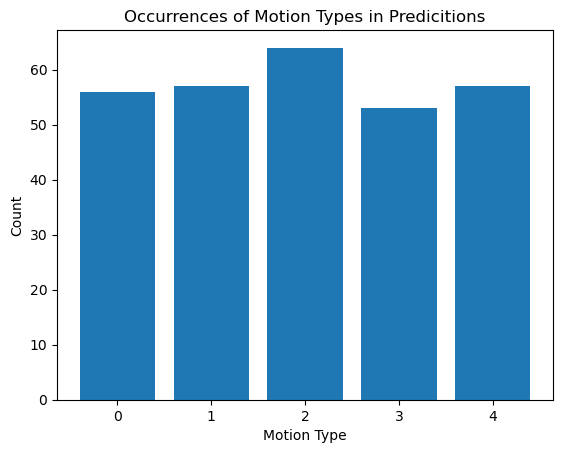

In [118]:
# Get the unique elements and their counts
unique_elements, counts = np.unique(y_pred_classes, return_counts=True)

# Plot the counts as a bar plot
plt.bar(unique_elements, counts)
plt.xlabel('Motion Type')
plt.ylabel('Count')
plt.title('Occurrences of Motion Types in Predicitions')
plt.show()